In [5]:
from google.colab import files
uploaded = files.upload()

Saving pd_model_data.csv to pd_model_data.csv


In [47]:
import pandas as pd
import numpy as np

In [48]:
df = pd.read_csv("pd_model_data.csv")

X = df.drop(columns = ['Approved_Flag','Risk_Band','Default'])
y = df['Default']

df.head()

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others,Approved_Flag,Risk_Band,Default
0,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,4.007171,-0.301164,0.486984,...,2.137564,-0.69322,-0.222723,-0.597817,-0.177799,2.914295,-0.981532,P2,LOW RISK,0
1,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.457912,-0.393981,...,-0.467822,-0.69322,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,P2,LOW RISK,0
2,-0.194333,-0.463527,-0.537022,-0.619580,0.428634,-0.265644,-0.212621,-0.357939,-0.144417,1.074294,...,-0.467822,-0.69322,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,P2,LOW RISK,0
3,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.012331,-0.687636,...,-0.467822,-0.69322,-0.222723,-0.597817,-0.177799,-0.343136,-0.981532,P1,VERY LOW RISK,0
4,-0.643909,-0.463527,0.113516,0.025637,-0.475174,-0.265644,-0.212621,-0.357939,0.482573,-0.687636,...,-0.467822,-0.69322,-0.222723,-0.597817,-0.177799,2.914295,-0.981532,P3,MEDIUM RISK,0


In [49]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(
    X,y,
    test_size = 0.25,
    stratify = y,
    random_state=42
)

In [50]:
dummy_accuracy = max(y_test.mean(),1-y_test.mean())
print("Dummy model accuracy:",round(dummy_accuracy,3))

Dummy model accuracy: 0.875


This code calculates the accuracy of a model that always predicts the majority class, showing why accuracy is misleading for imbalanced credit data.

In [51]:
from sklearn.metrics import roc_auc_score,average_precision_score

In [52]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(
    class_weight = {0:1,1:6},
    max_iter=1000
)

log_model.fit(X_train,y_train)
log_probs = log_model.predict_proba(X_test)[:,1]

In [53]:
from xgboost import XGBClassifier

pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb = XGBClassifier(
    scale_pos_weight = pos_weight,
    eval_metric = 'auc',
    random_state=42
)

xgb.fit(X_train,y_train)
xgb_probs = xgb.predict_proba(X_test)[:,1]

In [54]:
log_roc = roc_auc_score(y_test,log_probs)
log_pr = average_precision_score(y_test,log_probs)

xgb_roc = roc_auc_score(y_test,log_probs)
xgb_pr = average_precision_score(y_test,xgb_probs)

In [55]:
def ks_stat(y_true, y_prob):
    data = pd.DataFrame({'y':y_true,'p':y_prob})
    data = data.sort_values('p', ascending=False)
    data['cum_good'] = (data['y']==0).cumsum() / (data['y']==0).sum()
    data['cum_bad'] = (data['y']==1).cumsum() / (data['y']==1).sum()
    return max(abs(data['cum_bad'] - data['cum_good']))

log_ks = ks_stat(y_test, log_probs)
xgb_ks = ks_stat(y_test, xgb_probs)

log_ks, xgb_ks

(0.7300459230870886, 0.81290934320074)

In [56]:
results = pd.DataFrame({
    'Model':['Logistic Regression','XGBoost'],
    'ROC_AUC':[log_roc, xgb_roc],
    'PR_AUC':[log_pr, xgb_pr],
    'KS':[log_ks, xgb_ks]
})

results


,Model,ROC_AUC,PR_AUC,KS
0,Logistic Regression,0.937643,0.749878,0.730046
1,XGBoost,0.937643,0.830002,0.812909


In [57]:
threshold = 0.35

xgb_pred = (xgb_probs >= threshold).astype(int)
xgb_pred


array([1, 0, 0, ..., 0, 0, 1])

In [58]:
approval_rate = 1 - xgb_pred.mean()
default_rate = y_test[xgb_pred==0].mean()

print("approval rate:",round(approval_rate,3))
print("default rate:",round(default_rate,3))

approval rate: 0.804
default rate: 0.017


In [59]:
import shap


In [60]:
#create a tool that understands how XGBoost risk model works
explainer = shap.TreeExplainer(xgb)

In [61]:
explainer

In [62]:
#how much each feature pushed their default risk up or down
shap_values = explainer.shap_values(X_test)

In [63]:
shap_values

array([[-2.99765855e-01, -5.41399010e-02, -2.29412671e-02, ...,
        -3.31296440e-04,  1.42023386e-03,  6.92866221e-02],
       [-1.28051251e-01,  5.79960421e-02,  1.12958588e-02, ...,
        -1.19625111e-04, -8.49341601e-03,  1.75665691e-02],
       [-1.75750300e-01, -5.59381675e-03, -8.75858415e-04, ...,
        -2.10728816e-04, -9.89316124e-03, -2.37530991e-02],
       ...,
       [-3.89353573e-01, -1.13108136e-01, -7.32857138e-02, ...,
        -2.94957077e-04, -7.05740694e-03, -8.53464194e-03],
       [ 1.06259614e-01, -1.60197839e-01,  1.16001526e-02, ...,
        -1.89615320e-03, -1.22042792e-03,  1.70397721e-02],
       [-1.12148255e-01,  5.50601631e-04,  4.98277741e-03, ...,
        -2.54806504e-03, -1.20744035e-02, -3.73871438e-02]], dtype=float32)

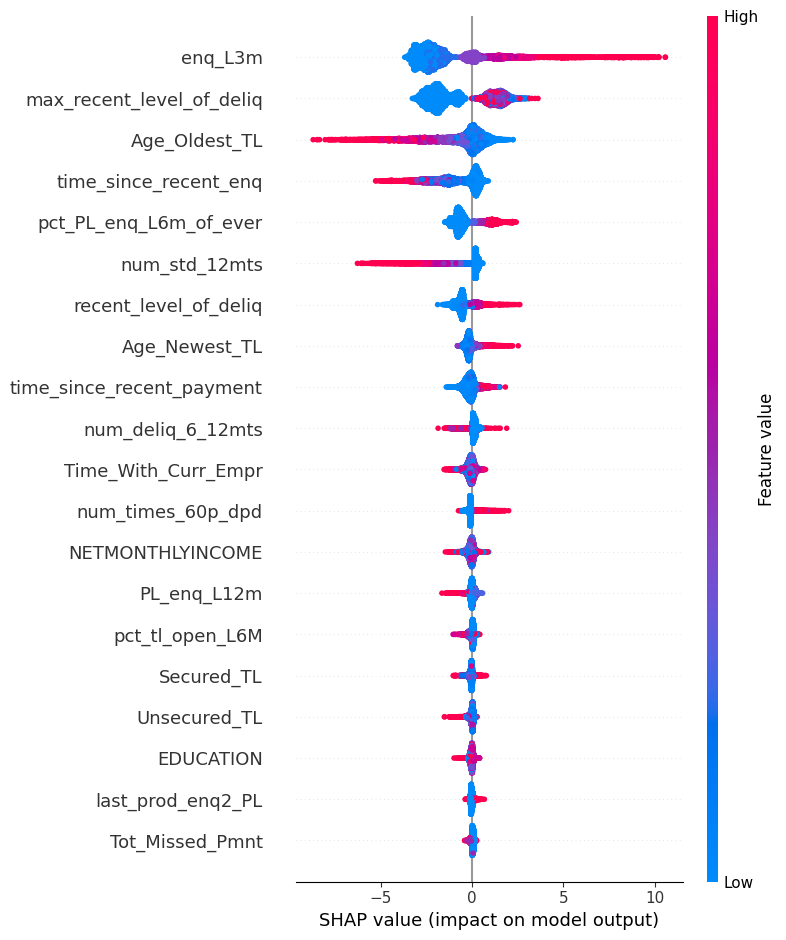

In [64]:
shap.summary_plot(shap_values,X_test)

In [65]:
rejected_idx = np.where(xgb_pred==1)[0][0]

In [66]:
rejected_idx

np.int64(0)

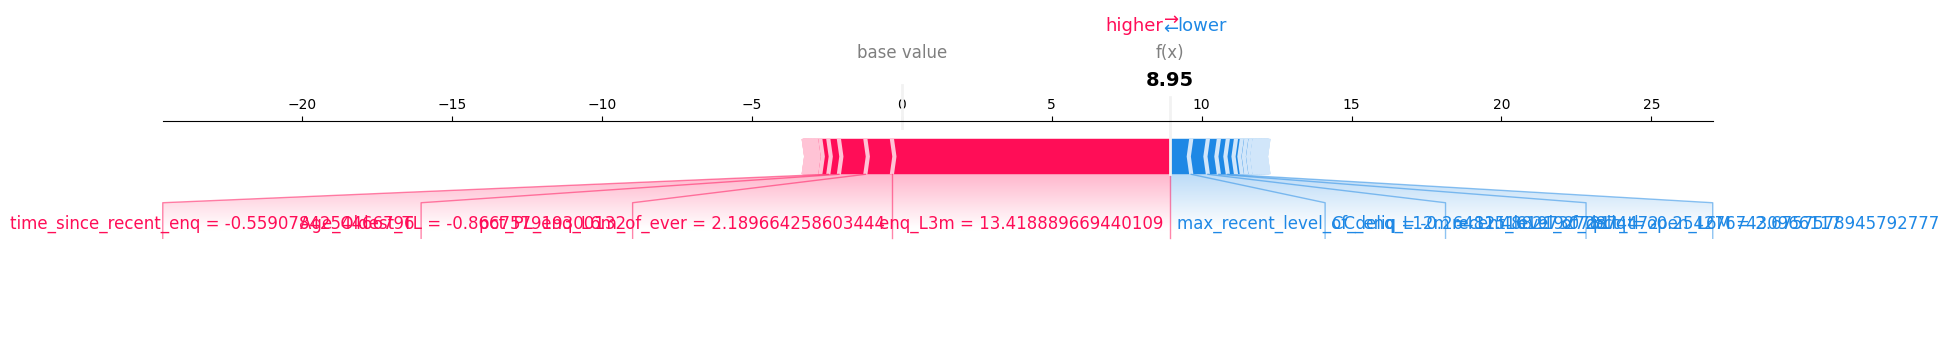

In [67]:
#creates a visual explanation for that one rejected person
import matplotlib.pyplot as plt

shap.force_plot(
    explainer.expected_value,
    shap_values[rejected_idx],
    X_test.iloc[rejected_idx],
    matplotlib=True
)


In [68]:
def assign_risk_band(pd):
  if pd<0.20:
    return "low risk"
  elif pd<0.50:
    return "medium risk"
  else:
    return "high risk"

In [69]:
df_test = X_test.copy()
df_test['PD'] = xgb_probs
df_test

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,last_prod_enq2_ConsumerLoan,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others,PD
10592,2.675758,0.631495,1.414592,0.272906,5.851486,1.554829,-0.212621,4.007171,0.325826,1.661604,...,-0.802591,-0.141877,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.999871
4194,0.553761,-0.463527,0.113516,0.666990,0.428634,-0.265644,-0.212621,-0.357939,-0.457912,0.193329,...,1.245964,-0.141877,-0.467822,-0.693220,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.328444
34891,-0.129594,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.639321,-0.687636,...,-0.802591,-0.141877,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.000184
2348,-0.643909,0.721561,0.113516,0.346313,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,0.193329,...,1.245964,-0.141877,-0.467822,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.164369
40838,0.553761,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.012331,-0.687636,...,-0.802591,-0.141877,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,-0.981532,0.018271
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24204,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.687636,...,-0.802591,-0.141877,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,2.914295,-0.981532,0.557248
2734,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.393981,...,-0.802591,-0.141877,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.716441
19411,1.755027,1.115010,0.113516,0.666990,0.428634,-0.265644,-0.212621,0.733338,-0.301164,-0.100326,...,-0.802591,-0.141877,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.002022
31189,-0.643909,4.276825,0.113516,3.243995,-0.475174,-0.265644,-0.212621,-0.357939,-0.457912,-0.393981,...,-0.802591,-0.141877,-0.467822,1.442544,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.000973


In [70]:
df_test['Actual_Default'] = y_test.values
df_test

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,last_prod_enq2_HL,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others,PD,Actual_Default
10592,2.675758,0.631495,1.414592,0.272906,5.851486,1.554829,-0.212621,4.007171,0.325826,1.661604,...,-0.141877,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.999871,1
4194,0.553761,-0.463527,0.113516,0.666990,0.428634,-0.265644,-0.212621,-0.357939,-0.457912,0.193329,...,-0.141877,-0.467822,-0.693220,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.328444,0
34891,-0.129594,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.639321,-0.687636,...,-0.141877,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.000184,0
2348,-0.643909,0.721561,0.113516,0.346313,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,0.193329,...,-0.141877,-0.467822,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.164369,0
40838,0.553761,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.012331,-0.687636,...,-0.141877,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,-0.981532,0.018271,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24204,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.687636,...,-0.141877,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,2.914295,-0.981532,0.557248,0
2734,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.393981,...,-0.141877,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.716441,0
19411,1.755027,1.115010,0.113516,0.666990,0.428634,-0.265644,-0.212621,0.733338,-0.301164,-0.100326,...,-0.141877,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.002022,0
31189,-0.643909,4.276825,0.113516,3.243995,-0.475174,-0.265644,-0.212621,-0.357939,-0.457912,-0.393981,...,-0.141877,-0.467822,1.442544,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.000973,0


In [71]:
df_test['Risk_Band'] = df_test['PD'].apply(assign_risk_band)
df_test

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,last_prod_enq2_PL,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others,PD,Actual_Default,Risk_Band
10592,2.675758,0.631495,1.414592,0.272906,5.851486,1.554829,-0.212621,4.007171,0.325826,1.661604,...,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.999871,1,high risk
4194,0.553761,-0.463527,0.113516,0.666990,0.428634,-0.265644,-0.212621,-0.357939,-0.457912,0.193329,...,-0.467822,-0.693220,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.328444,0,medium risk
34891,-0.129594,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.639321,-0.687636,...,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.000184,0,low risk
2348,-0.643909,0.721561,0.113516,0.346313,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,0.193329,...,-0.467822,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.164369,0,low risk
40838,0.553761,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.012331,-0.687636,...,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,-0.981532,0.018271,0,low risk
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24204,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.687636,...,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,2.914295,-0.981532,0.557248,0,high risk
2734,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.393981,...,-0.467822,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.716441,0,high risk
19411,1.755027,1.115010,0.113516,0.666990,0.428634,-0.265644,-0.212621,0.733338,-0.301164,-0.100326,...,2.137564,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.002022,0,low risk
31189,-0.643909,4.276825,0.113516,3.243995,-0.475174,-0.265644,-0.212621,-0.357939,-0.457912,-0.393981,...,-0.467822,1.442544,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.000973,0,low risk


In [72]:
def decision(band):
  if band == "low risk":
    return "approve"
  elif band == "medium risk":
    return "review"
  else:
    return "reject"

df_test['Decision'] = df_test['Risk_Band'].apply(decision)

In [73]:
df_test

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,last_prod_enq2_others,first_prod_enq2_CC,first_prod_enq2_ConsumerLoan,first_prod_enq2_HL,first_prod_enq2_PL,first_prod_enq2_others,PD,Actual_Default,Risk_Band,Decision
10592,2.675758,0.631495,1.414592,0.272906,5.851486,1.554829,-0.212621,4.007171,0.325826,1.661604,...,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.999871,1,high risk,reject
4194,0.553761,-0.463527,0.113516,0.666990,0.428634,-0.265644,-0.212621,-0.357939,-0.457912,0.193329,...,-0.693220,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.328444,0,medium risk,review
34891,-0.129594,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.639321,-0.687636,...,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.000184,0,low risk,approve
2348,-0.643909,0.721561,0.113516,0.346313,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,0.193329,...,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.164369,0,low risk,approve
40838,0.553761,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,0.012331,-0.687636,...,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,-0.981532,0.018271,0,low risk,approve
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24204,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.687636,...,-0.693220,-0.222723,-0.597817,-0.177799,2.914295,-0.981532,0.557248,0,high risk,reject
2734,-0.643909,-0.463527,-0.537022,-0.619580,-0.475174,-0.265644,-0.212621,-0.357939,-0.301164,-0.393981,...,1.442544,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.716441,0,high risk,reject
19411,1.755027,1.115010,0.113516,0.666990,0.428634,-0.265644,-0.212621,0.733338,-0.301164,-0.100326,...,-0.693220,-0.222723,-0.597817,-0.177799,-0.343136,1.018815,0.002022,0,low risk,approve
31189,-0.643909,4.276825,0.113516,3.243995,-0.475174,-0.265644,-0.212621,-0.357939,-0.457912,-0.393981,...,1.442544,-0.222723,1.672753,-0.177799,-0.343136,-0.981532,0.000973,0,low risk,approve


In [74]:
#approval rate
approved = df_test[df_test['Decision']=="approve"]
approved_rate = len(approved)/len(df_test)
approved_rate

0.7703499429440852

In [75]:
#default rate among approved
default_rate = approved['Actual_Default'].mean()

In [76]:
default_rate

np.float64(0.009998765584495741)

In [77]:
#expected loss
loan_amount = 100000
lgd = 0.40 #loss given default

approved.loc[:, 'Expected_Loss'] = approved['PD'] * loan_amount * lgd
total_loss = approved['Expected_Loss'].sum()

/tmp/ipython-input-2367120967.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  approved.loc[:, 'Expected_Loss'] = approved['PD'] * loan_amount * lgd


In [78]:
total_loss

np.float32(4045480.0)

In [79]:
pd.crosstab(df_test['Risk_Band'],df_test['Decision'])

Decision,approve,reject,review
Risk_Band,,,
high risk,0,1750,0
low risk,8101,0,0
medium risk,0,0,665


In [80]:
from google.colab import files
uploaded = files.upload()

Saving Unseen_Dataset.xlsx to Unseen_Dataset (1).xlsx


In [86]:
unseen = pd.read_excel("Unseen_Dataset.xlsx")
unseen.head()

,pct_tl_open_L6M,pct_tl_closed_L6M,Tot_TL_closed_L12M,pct_tl_closed_L12M,Tot_Missed_Pmnt,CC_TL,Home_TL,PL_TL,Secured_TL,Unsecured_TL,...,PL_Flag,pct_PL_enq_L6m_of_ever,pct_CC_enq_L6m_of_ever,HL_Flag,GL_Flag,MARITALSTATUS,EDUCATION,GENDER,last_prod_enq2,first_prod_enq2
0,0.000,0.0,0,0.000,0,0,0,4,1,4,...,1,0.000,0.0,1,0,Married,12TH,M,PL,PL
1,0.000,0.0,0,0.000,0,0,0,0,0,1,...,0,0.000,0.0,0,0,Single,GRADUATE,F,ConsumerLoan,ConsumerLoan
2,0.125,0.0,0,0.000,1,0,0,0,2,6,...,0,0.000,0.0,1,0,Married,SSC,M,ConsumerLoan,others
3,0.000,0.0,0,0.000,0,0,0,0,3,0,...,0,0.000,0.0,0,0,Married,POST-GRADUATE,M,AL,AL
4,0.000,0.0,1,0.167,0,0,0,0,6,0,...,0,0.429,0.0,1,0,Married,12TH,M,ConsumerLoan,PL


In [87]:
print(df.columns)

Index(['pct_tl_open_L6M', 'pct_tl_closed_L6M', 'Tot_TL_closed_L12M',
       'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'CC_TL', 'Home_TL', 'PL_TL',
       'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL',
       'Age_Newest_TL', 'time_since_recent_payment',
       'max_recent_level_of_deliq', 'num_deliq_6_12mts', 'num_times_60p_dpd',
       'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt',
       'num_dbt_12mts', 'num_lss', 'recent_level_of_deliq', 'CC_enq_L12m',
       'PL_enq_L12m', 'time_since_recent_enq', 'enq_L3m', 'NETMONTHLYINCOME',
       'Time_With_Curr_Empr', 'CC_Flag', 'PL_Flag', 'pct_PL_enq_L6m_of_ever',
       'pct_CC_enq_L6m_of_ever', 'HL_Flag', 'GL_Flag', 'EDUCATION',
       'MARITALSTATUS_Single', 'GENDER_M', 'last_prod_enq2_CC',
       'last_prod_enq2_ConsumerLoan', 'last_prod_enq2_HL', 'last_prod_enq2_PL',
       'last_prod_enq2_others', 'first_prod_enq2_CC',
       'first_prod_enq2_ConsumerLoan', 'first_prod_enq2_HL',
       'first_prod_e

In [88]:
print(unseen.columns)

Index(['pct_tl_open_L6M', 'pct_tl_closed_L6M', 'Tot_TL_closed_L12M',
       'pct_tl_closed_L12M', 'Tot_Missed_Pmnt', 'CC_TL', 'Home_TL', 'PL_TL',
       'Secured_TL', 'Unsecured_TL', 'Other_TL', 'Age_Oldest_TL',
       'Age_Newest_TL', 'time_since_recent_payment',
       'max_recent_level_of_deliq', 'num_deliq_6_12mts', 'num_times_60p_dpd',
       'num_std_12mts', 'num_sub', 'num_sub_6mts', 'num_sub_12mts', 'num_dbt',
       'num_dbt_12mts', 'num_lss', 'recent_level_of_deliq', 'CC_enq_L12m',
       'PL_enq_L12m', 'time_since_recent_enq', 'enq_L3m', 'NETMONTHLYINCOME',
       'Time_With_Curr_Empr', 'CC_Flag', 'PL_Flag', 'pct_PL_enq_L6m_of_ever',
       'pct_CC_enq_L6m_of_ever', 'HL_Flag', 'GL_Flag', 'MARITALSTATUS',
       'EDUCATION', 'GENDER', 'last_prod_enq2', 'first_prod_enq2'],
      dtype='object')


In [89]:
education_map = {
    'SSC':1,
    'UNDERGRADUATE':2,
    'GRADUATE':3,
    'POST-GRADUATE':4,
    'OTHERS':5
}


In [90]:
def prepare_unseen(unseen_raw, training_columns):
    df = unseen_raw.copy()

    # map education
    if 'EDUCATION' in df.columns:
        df['EDUCATION'] = df['EDUCATION'].map(education_map)

    # one-hot encode
    df = pd.get_dummies(df)

    # align with training
    for col in training_columns:
        if col not in df.columns:
            df[col] = 0

    df = df[training_columns]
    return df


In [92]:
unseen_ready = prepare_unseen(unseen, X.columns)


In [94]:
unseen['PD'] = xgb.predict_proba(unseen_ready)[:,1]

In [95]:
unseen['Risk_Band'] = unseen['PD'].apply(assign_risk_band)

In [96]:
train_dist = df_test['Risk_Band'].value_counts(normalize=True)
unseen_dist = unseen['Risk_Band'].value_counts(normalize=True)

In [97]:
pd.DataFrame({'Train':train_dist,'Unseen':unseen_dist})

,Train,Unseen
Risk_Band,,
high risk,0.166413,0.01
low risk,0.770350,0.92
medium risk,0.063237,0.07


In [98]:
import pickle

# Save model
pickle.dump(xgb, open("xgb_model.pkl","wb"))

# Save feature columns
pickle.dump(list(X.columns), open("columns.pkl","wb"))

# Save education mapping
education_map = {
    'SSC': 1,
    'UNDERGRADUATE': 2,
    'GRADUATE': 3,
    'POST-GRADUATE': 4,
    'OTHERS': 5
}
pickle.dump(education_map, open("education_map.pkl","wb"))

# Save risk policy
risk_policy = {
    "low":0.20,
    "medium":0.50
}
pickle.dump(risk_policy, open("risk_policy.pkl","wb"))
